<a href="https://colab.research.google.com/github/FarizKesten/CppPackagingExamples/blob/main/TestSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# useful segmentation model libraries
!pip install -q segmentation-models-pytorch > /dev/null 2>&1
!pip install -q PyWavelets opencv-python > /dev/null 2>&1

import os
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import segmentation_models_pytorch as smp


import matplotlib.pyplot as plt
from tqdm import tqdm

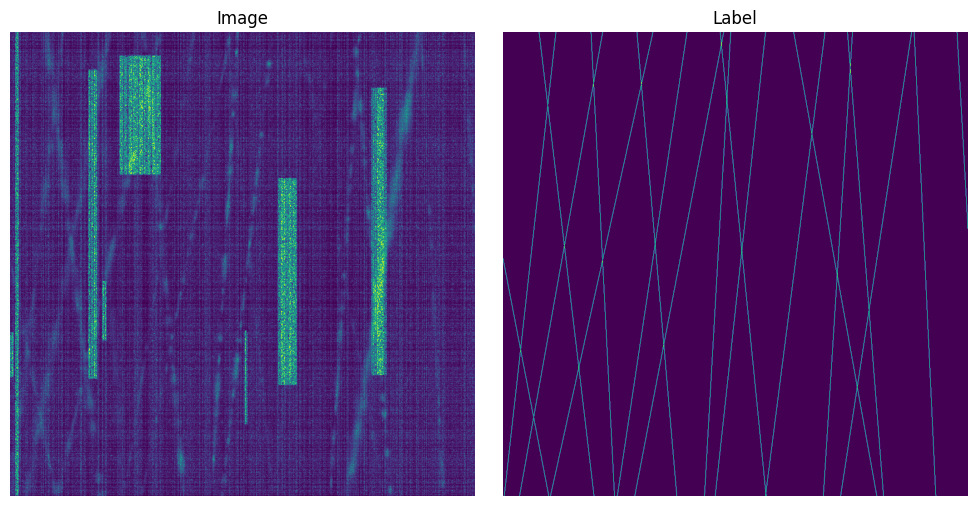

In [2]:
# try reading 1 image

import matplotlib.pyplot as plt

image = np.fromfile('/content/drive/MyDrive/ml_data/unet/cnn1/data/img/1.dat',dtype=np.single)
label = np.fromfile('/content/drive/MyDrive/ml_data/unet/cnn1/data/lbl/1.dat',dtype=np.single)

image_size = int(np.sqrt(len(image)))

image_reshaped = image.reshape((image_size, image_size))
labelimg_reshaped = label.reshape((image_size, image_size))


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_reshaped)
axes[0].set_title('Image')
axes[0].axis('off')

axes[1].imshow(labelimg_reshaped)
axes[1].set_title('Label')
axes[1].axis('off')

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)


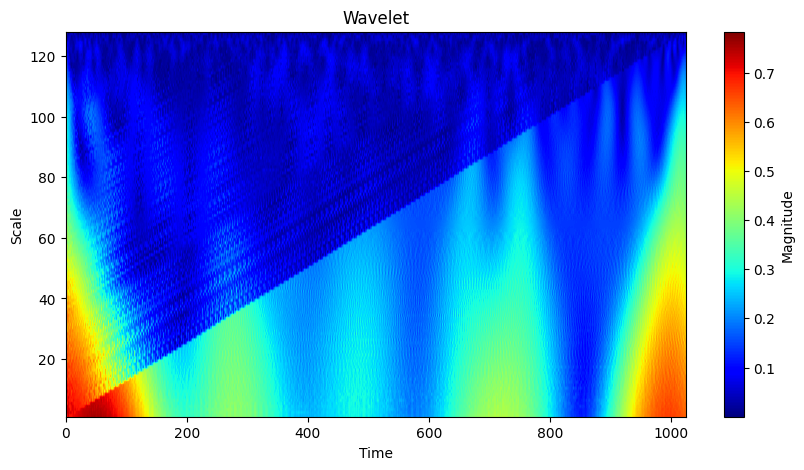

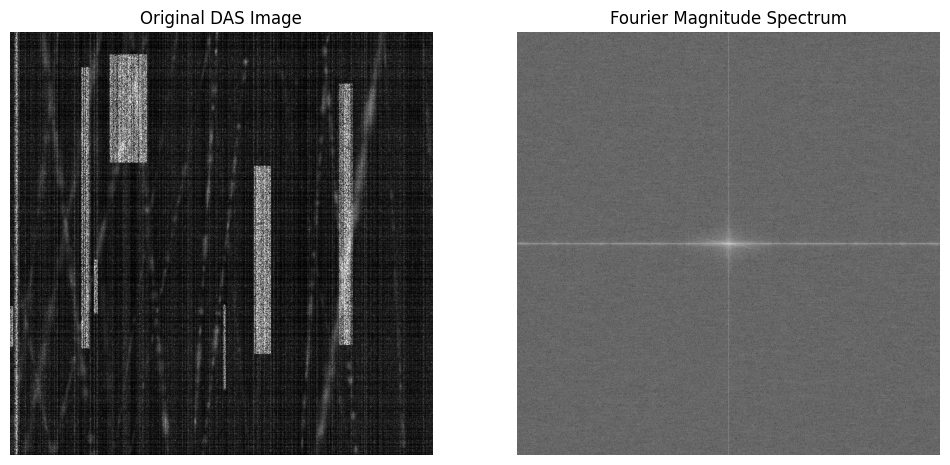

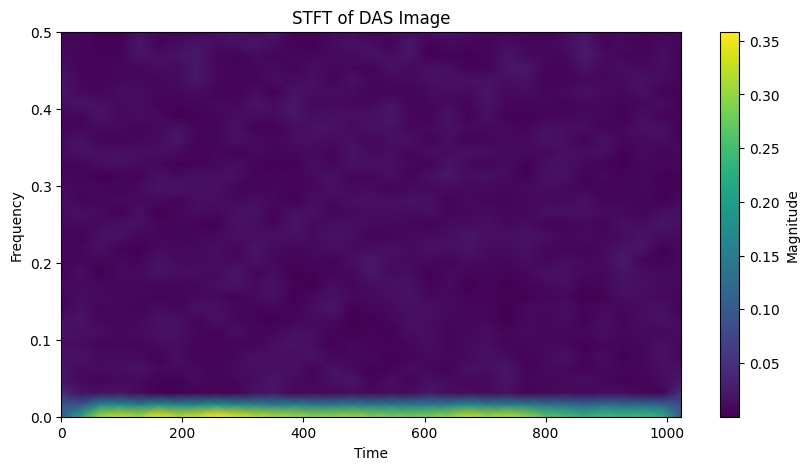

In [3]:
import pywt
import pywt.data


wavelet = 'cmor'

coeffs, frequencies = pywt.cwt(image_reshaped.mean(axis=1), scales=np.arange(1, 128), wavelet=wavelet)

# Plot Wavelet Transform
plt.figure(figsize=(10, 5))
plt.imshow(np.abs(coeffs), aspect='auto', cmap='jet', extent=[0, image_reshaped.shape[1], 1, 128])
plt.colorbar(label="Magnitude")
plt.xlabel("Time")
plt.ylabel("Scale")
plt.title("Wavelet")
plt.show()

# Apply 2D Fourier Transform
fft_image = np.fft.fft2(image_reshaped)
fft_shift = np.fft.fftshift(fft_image)  # Shift zero frequency to the center

# Compute Magnitude Spectrum
magnitude_spectrum = 20 * np.log(np.abs(fft_shift) + 1)  # Log for better visibility

# Display Original Image and Frequency Spectrum
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image_reshaped, cmap="gray")
axes[0].set_title("Original DAS Image")
axes[0].axis("off")

axes[1].imshow(magnitude_spectrum, cmap="gray")
axes[1].set_title("Fourier Magnitude Spectrum")
axes[1].axis("off")

plt.show()


import scipy.signal as signal

# Parameters
nperseg = 64  # Window size (adjust based on DAS data)

# Compute STFT
frequencies, times, Zxx = signal.stft(image_reshaped.mean(axis=1), fs=1.0, nperseg=nperseg)

# Plot STFT Magnitude
plt.figure(figsize=(10, 5))
plt.pcolormesh(times, frequencies, np.abs(Zxx), shading='gouraud')
plt.colorbar(label="Magnitude")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.title("STFT of DAS Image")
plt.show()



In [4]:
# TEST: get min max and statistic of labelimg_reshaped

print(np.min(labelimg_reshaped))
print(np.max(labelimg_reshaped))
print(np.median(labelimg_reshaped))
print(np.mean(labelimg_reshaped))
print(np.std(labelimg_reshaped))

0.0
1.0
0.0
0.01745987
0.13097715


In [24]:
# Create a model for the segmentation

# (1): use UNet

models = {
    "Unet": smp.Unet(
        encoder_name="resnet50",
        encoder_weights="imagenet",
        in_channels=1,
        classes=1
    ),

    "DeepLabV3Plus": smp.DeepLabV3Plus(
        encoder_name="resnet50",
        encoder_weights="imagenet",
        in_channels=1,
        classes=1
    ),

    "FPN": smp.FPN(
        encoder_name="resnet50",
        encoder_weights="imagenet",
        in_channels=1,
        classes=1
    ),

    "PAN": smp.PAN(
        encoder_name="resnet50",
        encoder_weights="imagenet",
        in_channels=1,
        classes=1
    ),

    "PSPNet": smp.PSPNet(
        encoder_name="resnet50",
        encoder_weights="imagenet",
        in_channels=1,
        classes=1
    ),
}

models = {
    "DeepLabV3Plus": smp.DeepLabV3Plus(
        encoder_name="resnet50",
        encoder_weights="imagenet",
        in_channels=1,
        classes=1
    ),
}

# printing all models that are used
for key, model in models.items():
  print(key)


DeepLabV3Plus


# Load & Transform Dataset


In [8]:
from sklearn.model_selection import train_test_split

file_names = os.listdir('/content/drive/MyDrive/ml_data/unet/cnn1/data/img')
train_files, rest_files = train_test_split(file_names, test_size=0.3, random_state=42)
val_files, test_files = train_test_split(rest_files, test_size=0.5, random_state=42)

print(len(train_files))
print(len(val_files))
print(len(test_files))

140
30
30


In [9]:
from torch.utils.data import Dataset
import torchvision.transforms as T
import torchvision.transforms.functional as F
import random



class SegmentationDataset(Dataset):
  def __init__(self, image_path, label_path, image_names, transform=False):
    self.image_path = image_path
    self.label_path = label_path
    self.transform = transform

    self.image_names = image_names

  def __len__(self):
    return len(self.image_names)


  def trans(self, image, label):
    '''
    add some randomness on the training dataset
    '''

    if random.random() > 0.5:
      image = F.hflip(image)
      label = F.hflip(label)

    if random.random() > 0.5:
      image = F.vflip(image)
      label = F.vflip(label)

    if random.random() > 0.5:
      angle = random.randint(-30, 30)
      image = F.rotate(image, angle)
      label = F.rotate(label, angle)

    return image, label


  def __getitem__(self, index):
    '''
    get both images and labels. in case a transform flag is set, apply a rando
    '''
    image_id = self.image_names[index]

    image = np.fromfile(os.path.join(self.image_path, image_id), dtype=np.single)
    label = np.fromfile(os.path.join(self.label_path, image_id), dtype=np.single)

    image_size = int(np.sqrt(len(image)))

    image = image.reshape((image_size, image_size))
    label = label.reshape((image_size, image_size))

    image = F.to_pil_image(image)
    label = F.to_pil_image(label)

    if self.transform:
      image, label = self.trans(image, label)


    # convert to tensors
    image_tensor = T.ToTensor()(image)
    label_tensor = T.ToTensor()(label)

    return image_tensor, label_tensor



In [10]:
from torch.utils.data import DataLoader

BATCH_SIZE = 4

#Instantiate the dataset

train_dataset = SegmentationDataset(
    image_path='/content/drive/MyDrive/ml_data/unet/cnn1/data/img',
    label_path='/content/drive/MyDrive/ml_data/unet/cnn1/data/lbl',
    image_names=train_files,
    transform=True
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = SegmentationDataset(
    image_path='/content/drive/MyDrive/ml_data/unet/cnn1/data/img',
    label_path='/content/drive/MyDrive/ml_data/unet/cnn1/data/lbl',
    image_names=val_files,
    transform=True
)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = SegmentationDataset(
    image_path='/content/drive/MyDrive/ml_data/unet/cnn1/data/img',
    label_path='/content/drive/MyDrive/ml_data/unet/cnn1/data/lbl',
    image_names=test_files,
    transform=False
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)


In [25]:
# Training

def train_one_epoch(model, loader, optimizer, criterion, device):
  model.train()
  running_loss = 0.0
  for images, labels in loader:
    images = images.to(device)
    labels = labels.to(device)


    # forward
    outputs = model(images)
    loss = criterion(outputs, labels)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  return running_loss / len(loader)


def evaluate(model, loader, criterion, device):
  model.eval()
  running_loss = 0.0
  with torch.no_grad():
    for images, labels in loader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)

      running_loss += loss.item()
  return running_loss / len(loader)


def eval_binary_class(pred, target, threshold=0.5):
  '''
  Use this to evaluatate the model so that we can compare the performances
  '''

  pred = torch.sigmoid(pred)
  pred = (pred > threshold).float()

  intersection = (pred * target ).sum().item()
  union = (pred + target ).sum().item() - intersection


  iou = intersection / union

  # precision & recall
  tp = intersection
  fp = pred.sum(dim=(2,3)) - tp
  fn = target.sum(dim=(2,3)) - tp

  precision = (tp + 1e-6) / (tp + fp + 1e-6)
  recall = (tp + 1e-6) / (tp + fn + 1e-6)

  return {
      "IOU" :iou.item(),
      "Precision": precision.mean().item(),
      "Recall": recall.mean().item(),
  }



In [28]:
NUMS_EPOCHS = 100

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


for key, model in models.items():
  best_val_loss = float('inf')

  model_dir = os.path.join('/content/drive/MyDrive/ml_data/unet/cnn1/data/mdls/', key)
  os.makedirs(model_dir, exist_ok=True)

  model.to(device)

  for epoch in range(NUMS_EPOCHS):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      torch.save(model.state_dict(), os.path.join(model_dir, 'best_model.pth'))
      print(f"New best model {key} saved at epoch {epoch+1}, Val Loss: {val_loss:.4f}")

    print(f"Epoch {epoch+1}/{NUMS_EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")



New best model DeepLabV3Plus saved at epoch 1, Val Loss: 0.0323
Epoch 1/100, Train Loss: 0.0334, Val Loss: 0.0323
New best model DeepLabV3Plus saved at epoch 2, Val Loss: 0.0316
Epoch 2/100, Train Loss: 0.0313, Val Loss: 0.0316
Epoch 3/100, Train Loss: 0.0313, Val Loss: 0.0319
New best model DeepLabV3Plus saved at epoch 4, Val Loss: 0.0306
Epoch 4/100, Train Loss: 0.0305, Val Loss: 0.0306
New best model DeepLabV3Plus saved at epoch 5, Val Loss: 0.0296
Epoch 5/100, Train Loss: 0.0299, Val Loss: 0.0296
New best model DeepLabV3Plus saved at epoch 6, Val Loss: 0.0296
Epoch 6/100, Train Loss: 0.0297, Val Loss: 0.0296
Epoch 7/100, Train Loss: 0.0297, Val Loss: 0.0298
New best model DeepLabV3Plus saved at epoch 8, Val Loss: 0.0288
Epoch 8/100, Train Loss: 0.0294, Val Loss: 0.0288
New best model DeepLabV3Plus saved at epoch 9, Val Loss: 0.0287
Epoch 9/100, Train Loss: 0.0288, Val Loss: 0.0287
Epoch 10/100, Train Loss: 0.0288, Val Loss: 0.0292
New best model DeepLabV3Plus saved at epoch 11, Val

<ipython-input-29-73e0a06d02fb>:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join('/content/drive/MyDrive/ml_data/unet/cnn1/dat

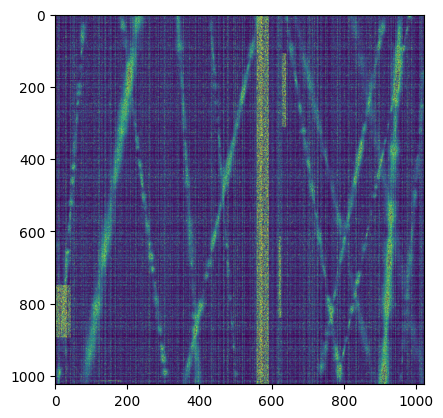

{'IOU': 0.28444905936965553, 'Precision': 0.6225103735923767, 'Recall': 0.3437407910823822}


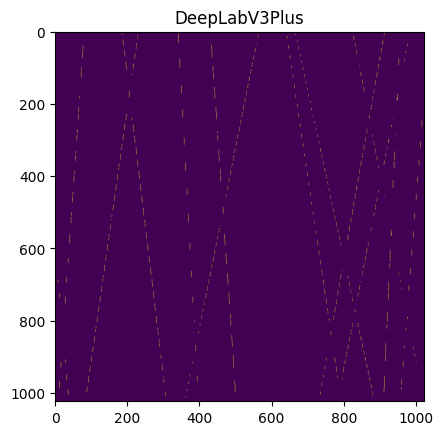

In [29]:

def preproc_image(image_path, device):
  image = np.fromfile(image_path, dtype=np.single)
  image_size = int(np.sqrt(len(image)))
  image = image.reshape((image_size, image_size))

  transform = T.Compose([
      T.ToPILImage(),
      #T.Resize((256,256)),
      T.ToTensor(),
  ])

  image = transform(image)
  image = image.unsqueeze(0)
  image = image.to(device)
  return image


def eval_binary_class(pred, target, threshold=0.5):
  '''
  Use this to evaluatate the model so that we can compare the performances
  '''

  pred = torch.sigmoid(pred)
  pred = (pred > threshold).float()

  intersection = (pred * target ).sum().item()
  union = (pred + target ).sum().item() - intersection


  iou = intersection / union

  # precision & recall
  tp = intersection
  fp = pred.sum(dim=(2,3)) - tp
  fn = target.sum(dim=(2,3)) - tp

  precision = (tp + 1e-6) / (tp + fp + 1e-6)
  recall = (tp + 1e-6) / (tp + fn + 1e-6)

  return {
      "IOU" :iou,
      "Precision": precision.mean().item(),
      "Recall": recall.mean().item(),
  }


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

b_show_image = True
for key, model in models.items():
  model.load_state_dict(torch.load(os.path.join('/content/drive/MyDrive/ml_data/unet/cnn1/data/mdls/', key, 'best_model.pth')))
  model.to(device)
  model.eval()


  with torch.no_grad():
    for images, labels in test_loader:
      if b_show_image:
        plt.imshow(images[0].squeeze())
        plt.show()
        b_show_image = False

      images = images.to(device)
      labels = labels.to(device)

      #output_logits = model(preproc_image('/content/drive/MyDrive/ml_data/unet/cnn1/data/img/1.dat', device))
      output_logits = model(images)

      batch_metrics = eval_binary_class(output_logits, labels)
      print(batch_metrics)

      output_logits = output_logits.cpu()
      output_logits = output_logits.squeeze(0).squeeze()
      output_logits = output_logits.numpy()
      output_logits = np.where(output_logits > 0.5, 1, 0)
      plt.imshow(output_logits)
      plt.title(key)
      plt.show()

      break

